device: cpu
test dataset: (20301, 2) 

sequential_model(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


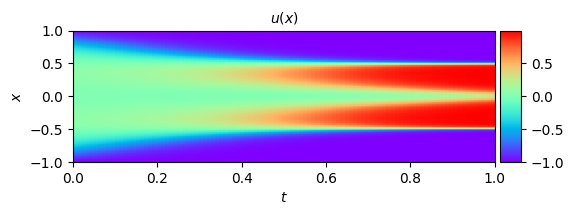

<AxesSubplot: title={'center': '$u(x)$'}, xlabel='$t$', ylabel='$x$'>

In [1]:
import numpy as np
import torch
import scipy.io

from visualization import *
from main import *
from used_attacks import regression_PGD

''' Settings and seeds '''

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device:", device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
    
''' test dataset '''

data = scipy.io.loadmat('usol_D_0.001_k_5.mat')

x = data['x'][0]
t = data['t'][0]
X, T = np.meshgrid(x,t)
U_gt = data['u'].T

x_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_test = U_gt.flatten('F')[:,None]
print("test dataset:", x_test.shape, '\n')

''' model '''

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = sequential_model(layers, device)
PINN.to(device)
print(PINN)
plot_u(U_gt, x, t, title="$u(x)$")

In [2]:
def generate_attack_samples(model, device, x_train, N0, n_samples=1000, \
    lb=[-1,0], ub=[1,1], steps=20, eps=2e-1, eta=2e-2, m=1):
    
    attack = regression_PGD(model, lb=lb, ub=ub, steps=steps, eps=eps, eta=eta)
    x_adv = attack.attack(x_train).cpu().detach().numpy()
    
    if x_adv.shape[0] > N0 + (m+1)*n_samples:
        x_adv = np.vstack([x_adv[:N0,:] ,x_adv[-(m+1)*n_samples:,:]])

    f_adv_pred = np.abs(model.function(x_adv).squeeze().cpu().detach().numpy())
    index = np.argsort(f_adv_pred)[::-1][:n_samples]
    x_adv = x_adv[index,:]
    f_adv_pred = f_adv_pred[index]
    
    plot_samples(x_adv, f_adv_pred)
    
    return x_adv


def retrain(model, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt, epoch=1e5):
    
    x_train_temp = np.vstack([x_train, x_adv])
    
    f_test_pred = np.abs(model.function(x_test).squeeze().cpu().detach().numpy())
    plot_u(f_test_pred.reshape(X.shape).T, x, t, log=True, title="test $r(x;theta)$")

    model.iter = 0
    optimizer = torch.optim.Adam(PINN.parameters(), lr=0.0001)
    model.train_model_adam(optimizer, x_boundary, u_boundary, x_train_temp, epoch)
                           
    rmse, u_pred = model.test(x_test, u_test)
    print('Test RMSE: %.5f'  % (rmse))
                           
    plot_u_x(u_pred.reshape(X.shape).T, U_gt, x, t)
    plot_u(np.abs(u_pred.reshape(X.shape).T-U_gt), x, t, log=True, title="$|u(x;theta)-u(x)|$")

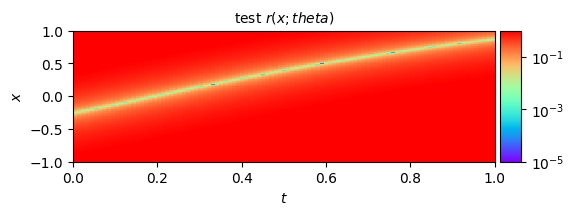

1000 tensor(0.0969, grad_fn=<AddBackward0>)
2000 tensor(0.0551, grad_fn=<AddBackward0>)
3000 tensor(0.0064, grad_fn=<AddBackward0>)
4000 tensor(0.0017, grad_fn=<AddBackward0>)
5000 tensor(0.0011, grad_fn=<AddBackward0>)
6000 tensor(0.0010, grad_fn=<AddBackward0>)
7000 tensor(0.0009, grad_fn=<AddBackward0>)
8000 tensor(0.0009, grad_fn=<AddBackward0>)
9000 tensor(0.0008, grad_fn=<AddBackward0>)
10000 tensor(0.0008, grad_fn=<AddBackward0>)
11000 tensor(0.0007, grad_fn=<AddBackward0>)
12000 tensor(0.0007, grad_fn=<AddBackward0>)
13000 tensor(0.0007, grad_fn=<AddBackward0>)
14000 tensor(0.0006, grad_fn=<AddBackward0>)
15000 tensor(0.0006, grad_fn=<AddBackward0>)
16000 tensor(0.0006, grad_fn=<AddBackward0>)
17000 tensor(0.0005, grad_fn=<AddBackward0>)
18000 tensor(0.0005, grad_fn=<AddBackward0>)
19000 tensor(0.0005, grad_fn=<AddBackward0>)
20000 tensor(0.0005, grad_fn=<AddBackward0>)
21000 tensor(0.0004, grad_fn=<AddBackward0>)
22000 tensor(0.0004, grad_fn=<AddBackward0>)
23000 tensor(0.0004

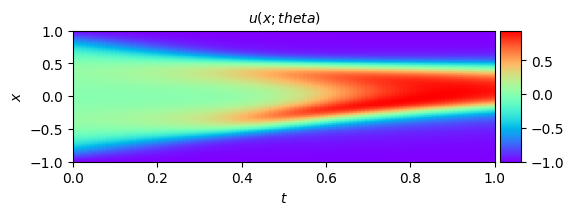

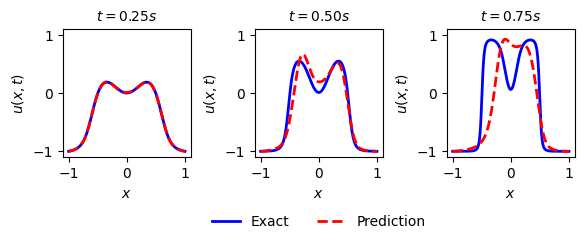

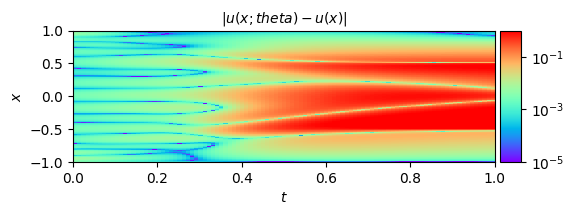

In [3]:
''' k=0 '''
N0 = 500
x_train, x_boundary, u_boundary = training_data_latin_hypercube(X, T, U_gt, N_inner=N0, ub=[1,0.2])
retrain(PINN, x_train, np.array([]).reshape((0,2)), \
    x_boundary, u_boundary, x_test, u_test, U_gt, epoch=1e5)


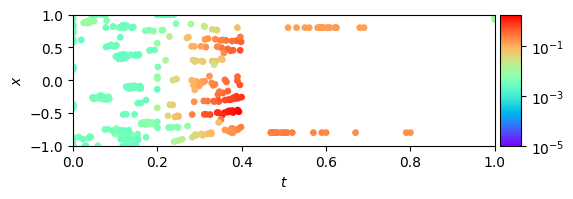

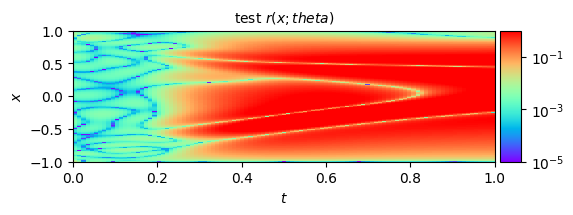

1000 tensor(0.0003, grad_fn=<AddBackward0>)
2000 tensor(0.0002, grad_fn=<AddBackward0>)
3000 tensor(0.0001, grad_fn=<AddBackward0>)
4000 tensor(8.7192e-05, grad_fn=<AddBackward0>)
5000 tensor(6.9167e-05, grad_fn=<AddBackward0>)
6000 tensor(5.7373e-05, grad_fn=<AddBackward0>)
7000 tensor(4.9420e-05, grad_fn=<AddBackward0>)
8000 tensor(4.3802e-05, grad_fn=<AddBackward0>)
9000 tensor(3.9530e-05, grad_fn=<AddBackward0>)
10000 tensor(4.4391e-05, grad_fn=<AddBackward0>)
11000 tensor(3.5300e-05, grad_fn=<AddBackward0>)
12000 tensor(3.1245e-05, grad_fn=<AddBackward0>)
13000 tensor(2.9411e-05, grad_fn=<AddBackward0>)
14000 tensor(2.7802e-05, grad_fn=<AddBackward0>)
15000 tensor(2.6405e-05, grad_fn=<AddBackward0>)
16000 tensor(2.5190e-05, grad_fn=<AddBackward0>)
17000 tensor(2.4059e-05, grad_fn=<AddBackward0>)
18000 tensor(2.3052e-05, grad_fn=<AddBackward0>)
19000 tensor(2.2179e-05, grad_fn=<AddBackward0>)
20000 tensor(3.9822e-05, grad_fn=<AddBackward0>)
21000 tensor(3.5038e-05, grad_fn=<AddBack

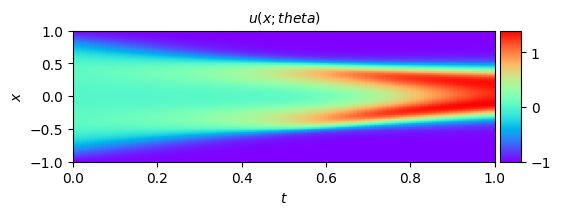

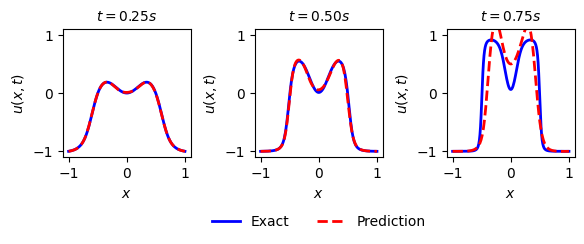

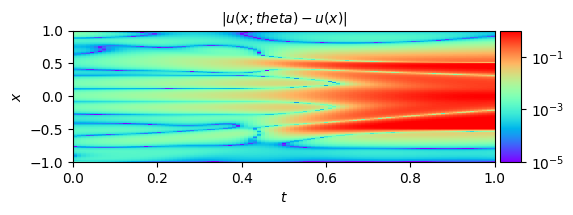

In [4]:
''' k=1 '''
x_adv = generate_attack_samples(PINN, device, x_train, N0, n_samples=500)
retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt)

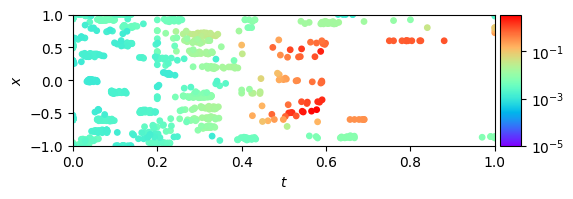

k= 2


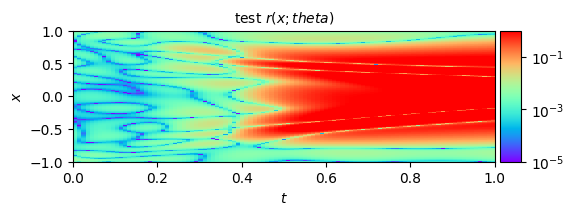

1000 tensor(0.0003, grad_fn=<AddBackward0>)
2000 tensor(0.0002, grad_fn=<AddBackward0>)
3000 tensor(0.0001, grad_fn=<AddBackward0>)
4000 tensor(0.0001, grad_fn=<AddBackward0>)
5000 tensor(8.6560e-05, grad_fn=<AddBackward0>)
6000 tensor(0.0002, grad_fn=<AddBackward0>)
7000 tensor(6.1321e-05, grad_fn=<AddBackward0>)
8000 tensor(5.2115e-05, grad_fn=<AddBackward0>)
9000 tensor(4.6063e-05, grad_fn=<AddBackward0>)
10000 tensor(3.9292e-05, grad_fn=<AddBackward0>)
11000 tensor(3.5008e-05, grad_fn=<AddBackward0>)
12000 tensor(3.3056e-05, grad_fn=<AddBackward0>)
13000 tensor(2.8979e-05, grad_fn=<AddBackward0>)
14000 tensor(2.6727e-05, grad_fn=<AddBackward0>)
15000 tensor(2.4804e-05, grad_fn=<AddBackward0>)
16000 tensor(2.3161e-05, grad_fn=<AddBackward0>)
17000 tensor(6.0161e-05, grad_fn=<AddBackward0>)
18000 tensor(2.0437e-05, grad_fn=<AddBackward0>)
19000 tensor(1.9304e-05, grad_fn=<AddBackward0>)
20000 tensor(2.2580e-05, grad_fn=<AddBackward0>)
21000 tensor(1.7391e-05, grad_fn=<AddBackward0>)


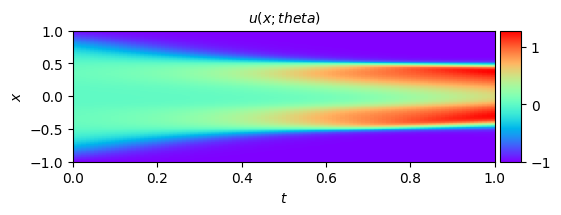

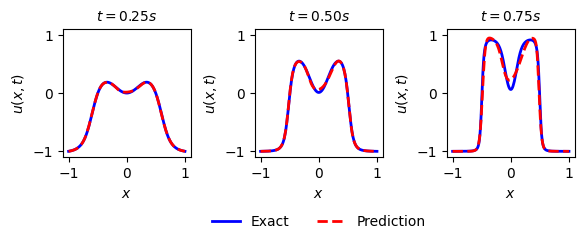

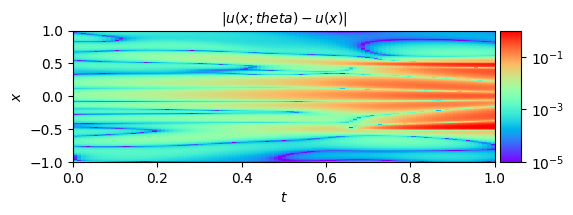

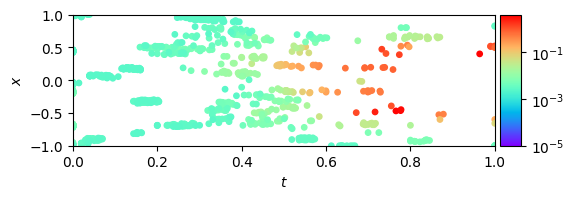

k= 3


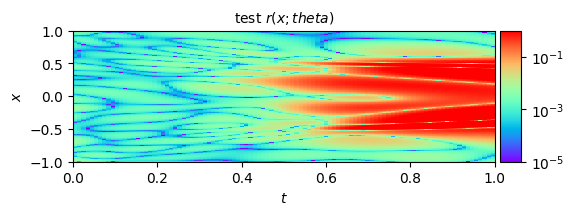

1000 tensor(0.0002, grad_fn=<AddBackward0>)
2000 tensor(0.0002, grad_fn=<AddBackward0>)
3000 tensor(0.0001, grad_fn=<AddBackward0>)
4000 tensor(0.0001, grad_fn=<AddBackward0>)
5000 tensor(8.4597e-05, grad_fn=<AddBackward0>)
6000 tensor(6.8936e-05, grad_fn=<AddBackward0>)
7000 tensor(5.7139e-05, grad_fn=<AddBackward0>)
8000 tensor(5.6662e-05, grad_fn=<AddBackward0>)
9000 tensor(4.8640e-05, grad_fn=<AddBackward0>)
10000 tensor(3.9810e-05, grad_fn=<AddBackward0>)
11000 tensor(3.6619e-05, grad_fn=<AddBackward0>)
12000 tensor(5.0546e-05, grad_fn=<AddBackward0>)
13000 tensor(2.9990e-05, grad_fn=<AddBackward0>)
14000 tensor(2.8420e-05, grad_fn=<AddBackward0>)
15000 tensor(2.5661e-05, grad_fn=<AddBackward0>)
16000 tensor(2.4956e-05, grad_fn=<AddBackward0>)
17000 tensor(2.2721e-05, grad_fn=<AddBackward0>)
18000 tensor(2.1325e-05, grad_fn=<AddBackward0>)
19000 tensor(2.0365e-05, grad_fn=<AddBackward0>)
20000 tensor(1.9314e-05, grad_fn=<AddBackward0>)
21000 tensor(1.8401e-05, grad_fn=<AddBackward

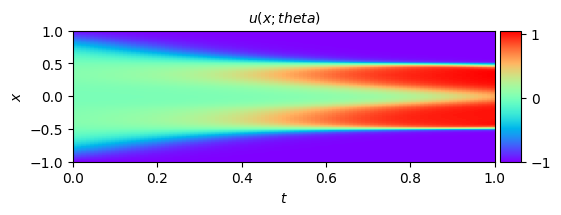

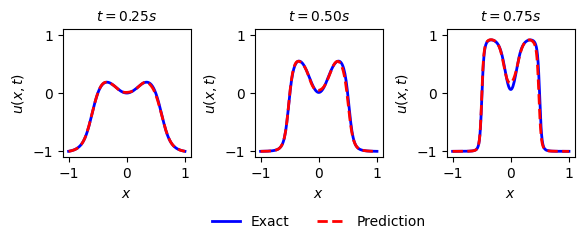

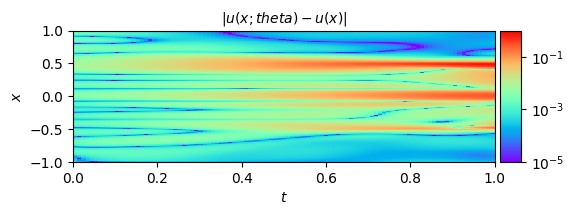

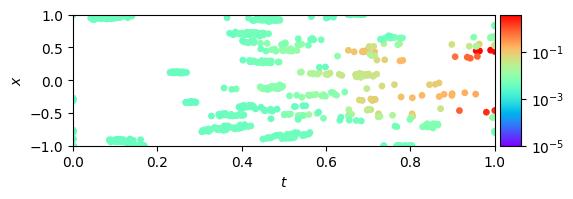

k= 4


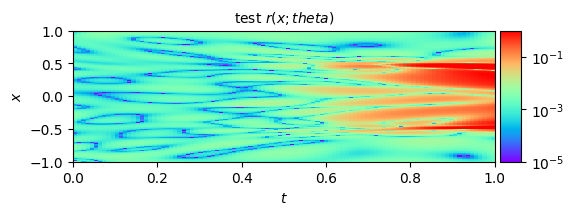

1000 tensor(7.6319e-05, grad_fn=<AddBackward0>)
2000 tensor(4.4113e-05, grad_fn=<AddBackward0>)
3000 tensor(4.9929e-05, grad_fn=<AddBackward0>)
4000 tensor(3.1704e-05, grad_fn=<AddBackward0>)
5000 tensor(2.2698e-05, grad_fn=<AddBackward0>)
6000 tensor(1.7597e-05, grad_fn=<AddBackward0>)
7000 tensor(1.5288e-05, grad_fn=<AddBackward0>)
8000 tensor(1.3665e-05, grad_fn=<AddBackward0>)
9000 tensor(1.2258e-05, grad_fn=<AddBackward0>)
10000 tensor(1.1234e-05, grad_fn=<AddBackward0>)
11000 tensor(1.0584e-05, grad_fn=<AddBackward0>)
12000 tensor(1.1347e-05, grad_fn=<AddBackward0>)
13000 tensor(9.1336e-06, grad_fn=<AddBackward0>)
14000 tensor(9.5242e-06, grad_fn=<AddBackward0>)
15000 tensor(8.2143e-06, grad_fn=<AddBackward0>)
16000 tensor(7.8674e-06, grad_fn=<AddBackward0>)
17000 tensor(7.5064e-06, grad_fn=<AddBackward0>)
18000 tensor(7.2244e-06, grad_fn=<AddBackward0>)
19000 tensor(6.9518e-06, grad_fn=<AddBackward0>)
20000 tensor(6.7124e-06, grad_fn=<AddBackward0>)
21000 tensor(6.5287e-06, grad

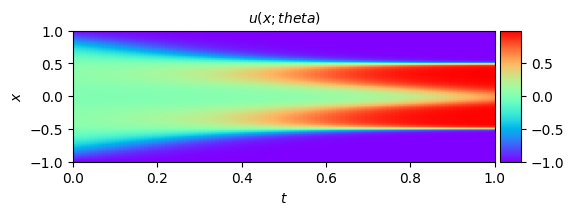

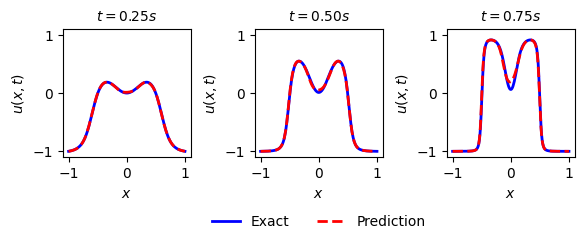

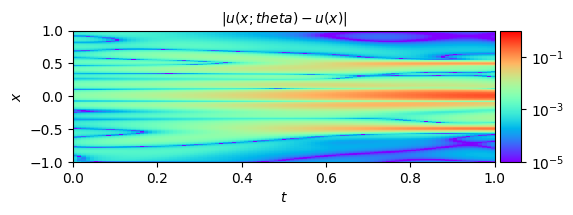

In [5]:
''' k=2 '''
for k in range(2,5):
    x_train = np.vstack([x_train, x_adv])
    x_adv = generate_attack_samples(PINN, device, x_train, N0)
    print("k=", k)
    retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt)

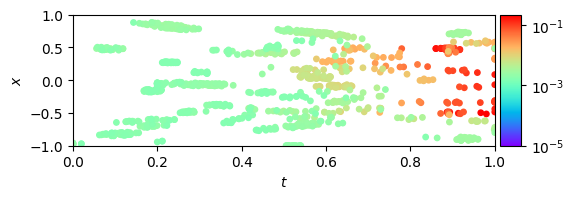

k= 5


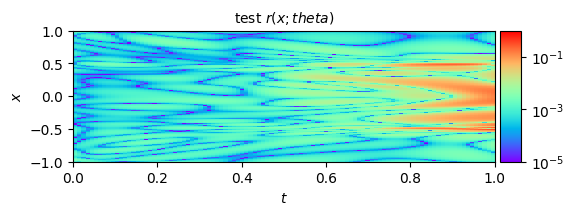

1000 tensor(3.1090e-05, grad_fn=<AddBackward0>)
2000 tensor(2.2300e-05, grad_fn=<AddBackward0>)
3000 tensor(1.7643e-05, grad_fn=<AddBackward0>)
4000 tensor(1.6669e-05, grad_fn=<AddBackward0>)
5000 tensor(1.3031e-05, grad_fn=<AddBackward0>)
6000 tensor(1.1720e-05, grad_fn=<AddBackward0>)
7000 tensor(1.7520e-05, grad_fn=<AddBackward0>)
8000 tensor(9.9704e-06, grad_fn=<AddBackward0>)
9000 tensor(9.2951e-06, grad_fn=<AddBackward0>)
10000 tensor(8.7663e-06, grad_fn=<AddBackward0>)
11000 tensor(8.2966e-06, grad_fn=<AddBackward0>)
12000 tensor(8.0766e-06, grad_fn=<AddBackward0>)
13000 tensor(7.5494e-06, grad_fn=<AddBackward0>)
14000 tensor(7.2722e-06, grad_fn=<AddBackward0>)
15000 tensor(9.2583e-06, grad_fn=<AddBackward0>)
16000 tensor(6.7101e-06, grad_fn=<AddBackward0>)
17000 tensor(1.0561e-05, grad_fn=<AddBackward0>)
18000 tensor(6.2369e-06, grad_fn=<AddBackward0>)
19000 tensor(6.0341e-06, grad_fn=<AddBackward0>)
20000 tensor(5.9076e-06, grad_fn=<AddBackward0>)
21000 tensor(5.8895e-06, grad

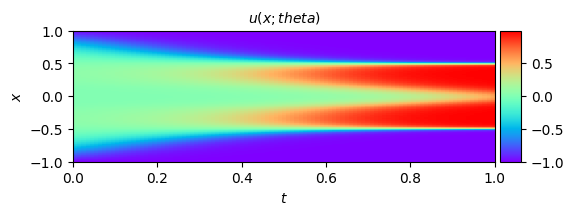

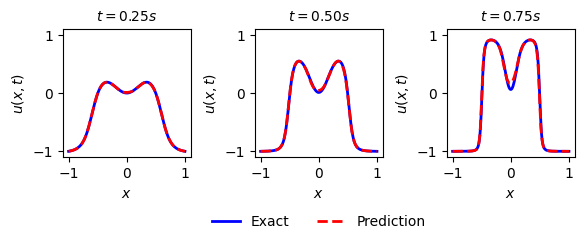

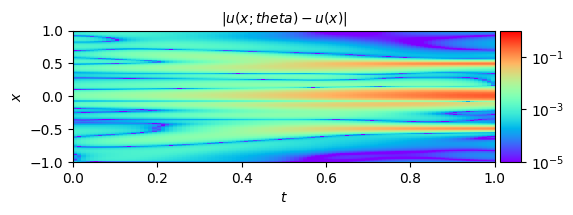

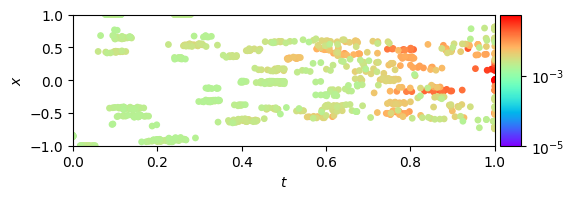

k= 6


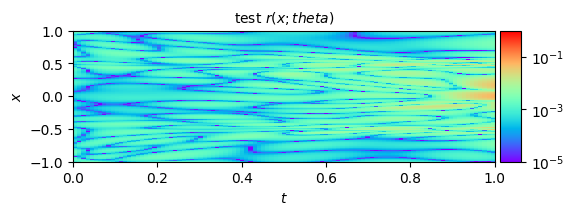

1000 tensor(5.7615e-06, grad_fn=<AddBackward0>)
2000 tensor(5.0089e-06, grad_fn=<AddBackward0>)
3000 tensor(5.1196e-06, grad_fn=<AddBackward0>)
4000 tensor(4.5251e-06, grad_fn=<AddBackward0>)
5000 tensor(4.2280e-06, grad_fn=<AddBackward0>)
6000 tensor(4.0783e-06, grad_fn=<AddBackward0>)
7000 tensor(4.2572e-06, grad_fn=<AddBackward0>)
8000 tensor(3.8622e-06, grad_fn=<AddBackward0>)
9000 tensor(3.9274e-06, grad_fn=<AddBackward0>)
10000 tensor(3.6924e-06, grad_fn=<AddBackward0>)
11000 tensor(3.6195e-06, grad_fn=<AddBackward0>)
12000 tensor(3.5561e-06, grad_fn=<AddBackward0>)
13000 tensor(3.4931e-06, grad_fn=<AddBackward0>)
14000 tensor(3.4331e-06, grad_fn=<AddBackward0>)
15000 tensor(3.3765e-06, grad_fn=<AddBackward0>)
16000 tensor(4.4192e-06, grad_fn=<AddBackward0>)
17000 tensor(3.3015e-06, grad_fn=<AddBackward0>)
18000 tensor(3.2587e-06, grad_fn=<AddBackward0>)
19000 tensor(3.1775e-06, grad_fn=<AddBackward0>)
20000 tensor(3.1397e-06, grad_fn=<AddBackward0>)
21000 tensor(3.1032e-06, grad

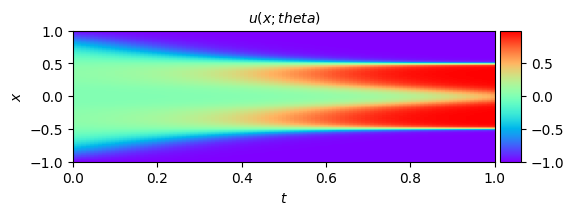

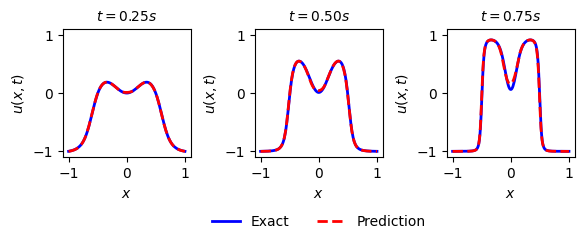

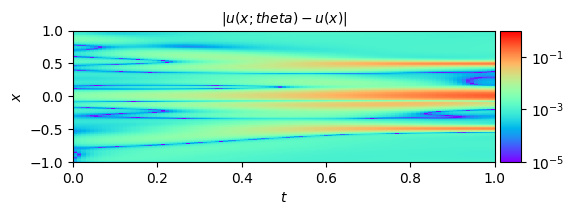

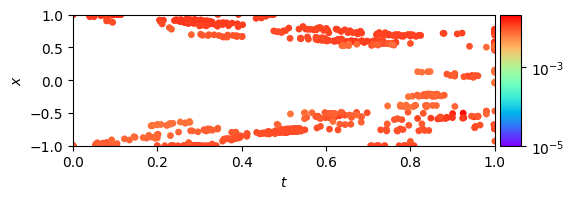

k= 7


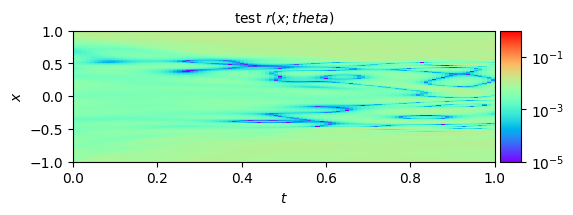

1000 tensor(1.9587e-06, grad_fn=<AddBackward0>)
2000 tensor(2.5783e-06, grad_fn=<AddBackward0>)
3000 tensor(1.9047e-06, grad_fn=<AddBackward0>)
4000 tensor(1.8902e-06, grad_fn=<AddBackward0>)
5000 tensor(1.8782e-06, grad_fn=<AddBackward0>)
6000 tensor(1.8661e-06, grad_fn=<AddBackward0>)
7000 tensor(1.8544e-06, grad_fn=<AddBackward0>)
8000 tensor(1.8422e-06, grad_fn=<AddBackward0>)
9000 tensor(1.8323e-06, grad_fn=<AddBackward0>)
10000 tensor(1.8203e-06, grad_fn=<AddBackward0>)
11000 tensor(1.8100e-06, grad_fn=<AddBackward0>)
12000 tensor(1.8009e-06, grad_fn=<AddBackward0>)
13000 tensor(1.7922e-06, grad_fn=<AddBackward0>)
14000 tensor(1.7831e-06, grad_fn=<AddBackward0>)
15000 tensor(1.7763e-06, grad_fn=<AddBackward0>)
16000 tensor(1.7692e-06, grad_fn=<AddBackward0>)
17000 tensor(1.7597e-06, grad_fn=<AddBackward0>)
18000 tensor(1.7514e-06, grad_fn=<AddBackward0>)
19000 tensor(1.7428e-06, grad_fn=<AddBackward0>)
20000 tensor(3.0798e-06, grad_fn=<AddBackward0>)
21000 tensor(1.7276e-06, grad

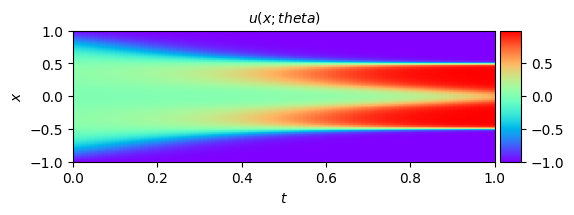

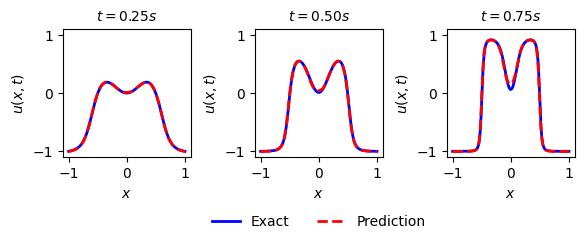

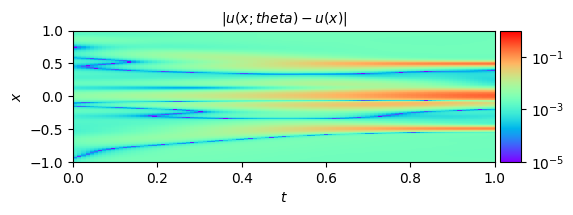

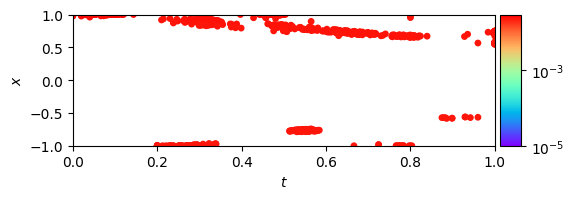

k= 8


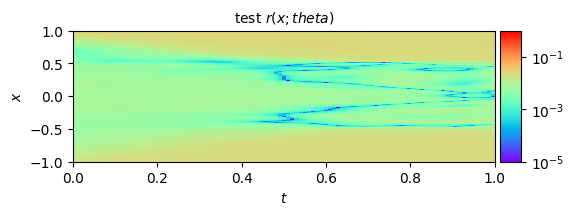

1000 tensor(1.2127e-06, grad_fn=<AddBackward0>)
2000 tensor(0.0012, grad_fn=<AddBackward0>)
3000 tensor(1.2065e-06, grad_fn=<AddBackward0>)
4000 tensor(1.2036e-06, grad_fn=<AddBackward0>)
5000 tensor(1.2000e-06, grad_fn=<AddBackward0>)
6000 tensor(1.1994e-06, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [6]:
''' k=5 '''
for k in range(5,10):
    x_train = np.vstack([x_train, x_adv])
    x_adv = generate_attack_samples(PINN, device, x_train, N0)
    print("k=", k)
    retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt)